<h2>Knn Regression</h2>

In [112]:
import numpy as np
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
from IPython import get_ipython

get_ipython().run_line_magic('matplotlib', 'inline')

<h3>Define helper functions</h3>

In [113]:
def get_csv(path: str) -> pd.DataFrame:
    
    return pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price', '24h High (USD)': 'high', '24h Low (USD)': 'low'})

<h3>Import data</h3>

In [114]:
df_ada = get_csv('./data/Cardano.csv')

<h3>Problems with using knn with stock/crypto price</h3>
<p>
    Knn regression is useful when we want to predict some values of an object based on that object other values. However, when it comes to predicting the prices of tomorrow's cryptos, there's a problem: we don't know anything about the tomorrow's, so instead, we should infer the price of tomorrow's cryptos using today's data.
</p>

In [115]:
def transform_df(df: pd.DataFrame) -> pd.DataFrame:

    transformed_df = pd.DataFrame(columns = ['date', 'price', 'previous price', 'previous high', 'previous low'])

    for i in range(1, df.shape[0]):
        transformed_df.loc[i - 1] = {'date': df.loc[i]['date'], 'price': df.loc[i]['price'], 'previous price': df.loc[i - 1]['price'], 'previous high': df.loc[i - 1]['high'], 'previous low': df.loc[i - 1]['low']}

    return transformed_df

In [116]:
df_ada = transform_df(get_csv('./data/Cardano.csv'))

<h3>Knn Regression</h3>
<p>
    The function define below is an crude implementation of knn. It takes in a training dataset as df, prediction dataset as x, and k as the order of knn, which then returns the prediction dataset with prediction column. This implementation also weigh the distance for better results.
</p>

In [117]:
def knn(df: pd.DataFrame, x: pd.Series, k: int) -> pd.DataFrame:

    pred = pd.DataFrame(index = x.index, columns = ['pred'])
    train = df.drop(columns = ['date'])
    pred_x = x.drop(columns = ['date'])

    for i in range(pred_x.shape[0]):
        distance = np.sqrt(np.sum((train - pred_x.iloc[i]) ** 2, axis = 1)).sort_values()
        weight_sum = sum(1 / distance.iloc[:k])
        pred.iloc[i] = np.sum([train.loc[distance.index[n]]['price'] / distance.iloc[n] for n in range(k)]) / weight_sum
        
    return x.assign(prediction = pred['pred'])

<p>
    Test to see if the function works...
</p>

In [118]:
pred = knn(df_ada[:ma.floor(df_ada.shape[0] * 0.7)], df_ada[ma.floor(df_ada.shape[0] * 0.7):].drop(columns = ['price']), 5)
pred

,date,previous price,previous high,previous low,prediction
193,2021-10-13,2.172090,2.249741,2.110711,2.184429
194,2021-10-14,2.117703,2.172186,2.072231,2.102739
195,2021-10-15,2.188204,2.198748,2.080997,2.19626
196,2021-10-16,2.173712,2.223790,2.157704,2.195264
197,2021-10-17,2.217599,2.241912,2.137200,2.225013
...,...,...,...,...,...
272,2021-12-31,1.331352,1.437200,1.323200,1.347456
273,2022-01-01,1.358500,1.378057,1.298746,1.338867
274,2022-01-02,1.308127,1.381830,1.281100,1.322832
275,2022-01-03,1.379002,1.379101,1.305360,1.344815


<p>It does, cool</p>

<h3>Finding the Right k Value</h3>
<p>
    Using the mean absolute percentage error in combaination with the root mean square error, we can observe the best value of k.
</p>

In [130]:
def rolling_knn(df: pd.DataFrame, k: int, test_ratio: float = 0.3) -> pd.DataFrame:

    test = df.drop(columns = ['date'])[ma.floor(df.shape[0] * (1 - test_ratio)):]
    pred = pd.DataFrame(index = test.index, columns = ['pred'])

    for i in test.index:
        train = df.drop(columns = ['date'])[:i]
        distance = np.sqrt(np.sum((train - test.loc[i]) ** 2, axis = 1)).sort_values()
        weight_sum = sum(1 / distance.iloc[:k])
        pred.loc[i] = np.sum([train.loc[distance.index[n]]['price'] / distance.iloc[n] for n in range(k)]) / weight_sum
        
    return pd.DataFrame({'date': df[ma.floor(df.shape[0] * (1 - test_ratio)):]['date'], 'pred': pred['pred'], 'real': test['price']}).set_index('date')

In [134]:
def test_for_k(df: pd.DataFrame, max_k: int = 5, test_ratio: float = 0.3) -> pd.DataFrame:
    
    k_error = pd.DataFrame(columns = ['mape', 'rmse'], dtype = np.float64)

    for k in range(1, max_k + 1):
        pred = rolling_knn(df, k, test_ratio)
        MAPE = np.round(np.mean(abs(1 - (pred['pred'] / pred['real']))) * 100, 2)
        RMSE = np.sqrt(np.mean((pred['real'] - pred['pred']) ** 2))
        k_error.loc[k] = {'mape': MAPE, 'rmse': RMSE}

    return k_error

In [135]:
ks = test_for_k(df_ada, 30)

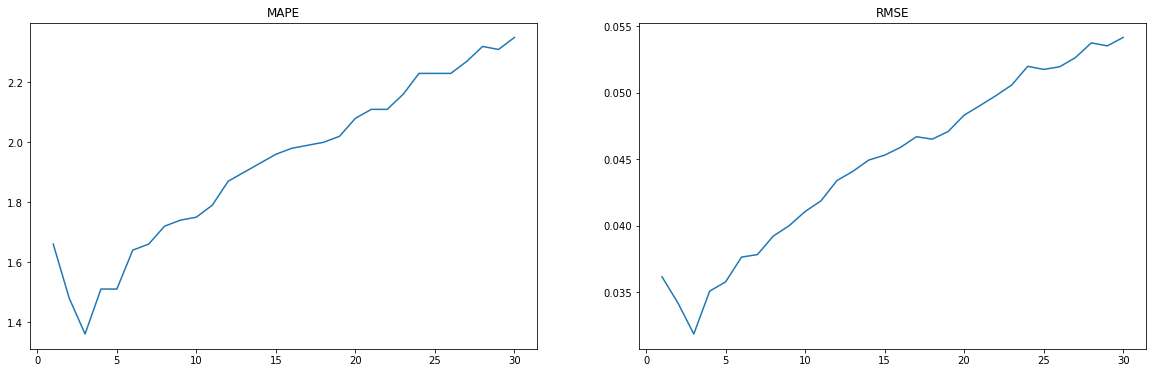

In [137]:
fig, axes = plt.subplots(1, 2, figsize = (20,6))
axes[0].plot(ks['mape'])
axes[0].set_title('MAPE')
axes[1].plot(ks['rmse'])
axes[1].set_title('RMSE')
plt.show()

<p>
    From the plot above we can see that as k gets larger the model tends to be more accurate.
    <br/>
    So, lets zoom in to see which k value have the lowest error for both MAPE and RMSE.
</p>

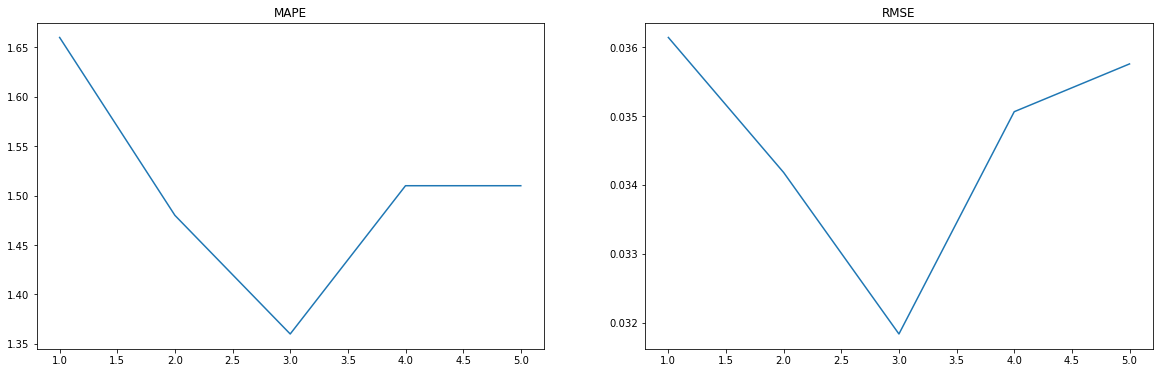

In [139]:
fig, axes = plt.subplots(1, 2, figsize = (20,6))
axes[0].plot(ks['mape'][:5])
axes[0].set_title('MAPE')
axes[1].plot(ks['rmse'][:5])
axes[1].set_title('RMSE')
plt.show()

<p>
    It would seems like 3 is the best value for k value. Lets try it and see how well it perfrom.
</p>

In [140]:
pred_ada = rolling_knn(df_ada, 3)

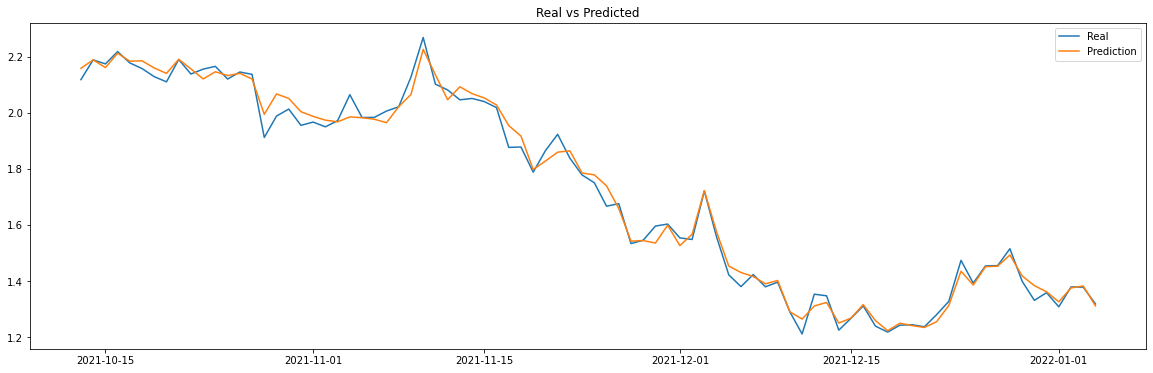

In [141]:
plt.figure(figsize=(20,6))
plt.title('Real vs Predicted')
plt.plot(pred_ada['real'], label = 'Real')
plt.plot(pred_ada['pred'], label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [143]:
print('MAPE:', np.round(np.mean(abs(1 - (pred_ada['pred'] / pred_ada['real']))) * 100, 2), '%')

MAPE: 1.36 %


In [144]:
df_eth = transform_df(get_csv('./data/ethereum.csv'))

In [145]:
ks_eth = test_for_k(df_eth, 10)

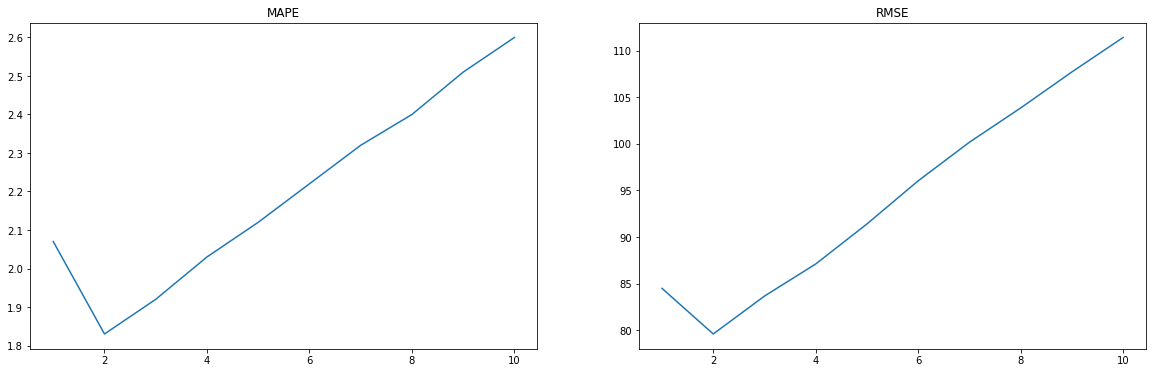

In [146]:
fig, axes = plt.subplots(1, 2, figsize = (20,6))
axes[0].plot(ks_eth['mape'])
axes[0].set_title('MAPE')
axes[1].plot(ks_eth['rmse'])
axes[1].set_title('RMSE')
plt.show()

In [147]:
pred_eth = rolling_knn(df_eth, 2)

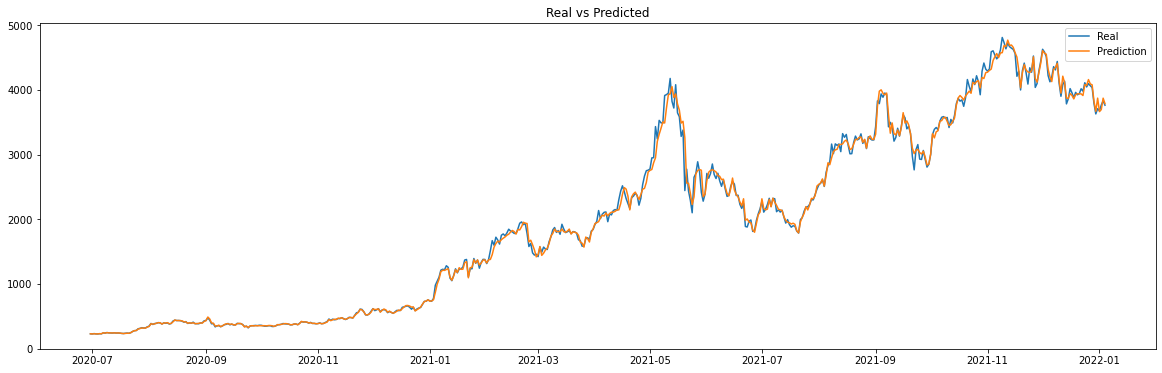

In [154]:
plt.figure(figsize=(20,6))
plt.title('Real vs Predicted')
plt.plot(pred_eth['real'], label = 'Real')
plt.plot(pred_eth['pred'], label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [156]:
print('MAPE:', np.round(np.mean(abs(1 - (pred_eth['pred'] / pred_eth['real']))) * 100, 2), '%')

MAPE: 1.83 %
